In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import logging

logger = logging.getLogger('')
logger.setLevel(logging.INFO)

from helper import Camera
import pickle
import scipy


In [2]:
const_rl_ddl = 200
const_warm_up = 2
const_final_round  = const_rl_ddl - 1
def spearmanFromActProb(rank, act_prob):
    x = [act_prob[i] for i in rank]
    y = [c for c in range(len(rank))]
    return scipy.stats.spearmanr(x,y)[0]
def spearmanSequenceFromActProbList(rank, act_probList):
    cos = []
    for act_prob in act_probList:
        cos.append(spearmanFromActProb(rank, act_prob))
    return np.array(cos)
def evaluateContributionsFromLogs(logs, client_nums):
    contirbution = []
    ddl = len(logs)
    for r in range(ddl):
        contirbution.append([0 for c in range(client_nums)])
    pprev_acc = logs[0].acc
    prev_participants = logs[1].participants
    prev_acc = logs[1].acc
    for r in range(2, ddl):
        for c in range(client_nums):
            contirbution[r][c] = contirbution[r-1][c]
        participants, acc = logs[r].participants, logs[r].acc
        if acc - prev_acc > prev_acc - pprev_acc:
            for c in prev_participants:
                contirbution[r][c] -= 1
            for c in participants:
                contirbution[r][c] += 1
        
        if acc < prev_acc:
            for c in participants:
                contirbution[r][c] -= 1
    return contirbution

In [3]:
# MLP         MNIST/FMNIST    5/25/100  seed=2-5    =2*3*4 = 24
# CNN         CIFAR10         5/25/100  seed=2-5    =1*3*4 = 12
# RESNET18    CIFAR100        5/25/100  seed=2-5    =1*3*4 = 12

In [4]:
def spearmanOfRoundFromCamera(camera, curr_round):
    act_probs = camera.act_probLogs[curr_round]
    contributions = evaluateContributionsFromLogs(camera.getRpmLogs(curr_round), camera.client_nums)
    sco_rl = spearmanSequenceFromActProbList(camera.rank, act_probs)
    sco_qi = spearmanSequenceFromActProbList(camera.rank, contributions[const_warm_up:])
    return sco_rl, sco_qi

In [6]:
with open('camera/cn5_pn3_dFMNIST_aMLP_piid_seed3.camera', 'rb') as f:
    camera = pickle.load(f)
curr_round = 4
sco_rl, sco_qi = spearmanOfRoundFromCamera(camera, curr_round)
# 合法轮数: const_warm_up 到 const_final_round
final_spearman_co_rl = sco_rl[const_final_round]
final_spearman_co_qi = sco_qi[const_final_round]

final_spearman_co_rl, final_spearman_co_qi

(0.7999999999999999, 0.6)

In [12]:
rl = []
qi = []
for seed in [2,3,4,5]:
    with open('camera/cn100_pn10_dMNIST_aMLP_piid_seed{}.camera'.format(seed), 'rb') as f:
        camera = pickle.load(f)
    t_rl = []
    t_qi = []
    for curr_round in range(5):
        sco_rl, sco_qi = spearmanOfRoundFromCamera(camera, curr_round)
        t_rl.append(sco_rl[const_final_round])
        t_qi.append(sco_qi[const_final_round])
    rl += t_rl
    qi += t_qi

/root/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [13]:
rl

[0.5887668766876687,
 0.5972517251725171,
 0.5672127212721272,
 0.5497269726972697,
 0.5745334533453345,
 0.4927572757275727,
 0.45491749174917484,
 0.4483408340834083,
 0.4481248124812481,
 0.4751995199519952,
 0.5145394539453945,
 0.5211641164116411,
 0.498985898589859,
 0.46346234623462346,
 0.4648784878487848,
 0.5929792979297929,
 0.6087128712871287,
 0.5919831983198318,
 0.5497629762976297,
 0.517071707170717]

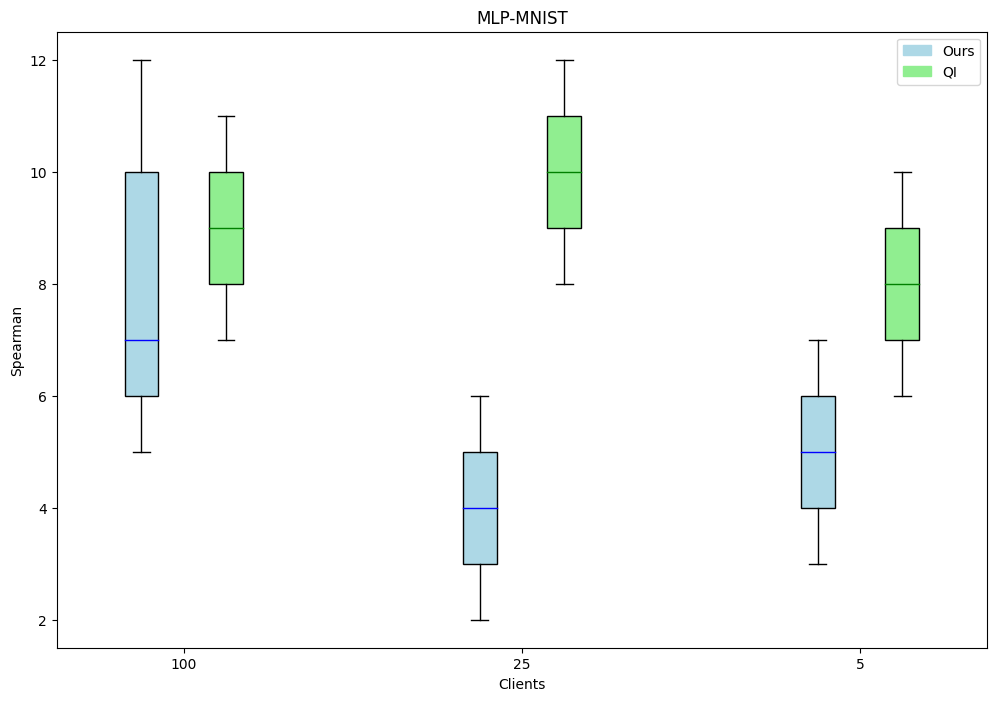

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 替换下面的数据和描述
client_numbers = [100, 25, 5]



mlp_spearman_values=[[10,12,7,6,5],[2,3,4,5,6],[3,4,5,6,7],]
qi_spearman_values = [
[7, 8, 9, 10, 11],
[8, 9, 10, 11, 12],
[6, 7, 8, 9, 10]
]
# 绘制箱型图
plt.figure(figsize=(12, 8))
numbers = [2, 4, 6]
positions_mlp = np.array(numbers) - 0.25
positions_qi = np.array(numbers) + 0.25
# 绘制MLP数据的箱型图
#plt.boxplot(mlp_spearman_values, labels=["Ours-100","QI-100","Ours-25","QI-25","Ours-5","QI-5"] , widths=0.8, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.boxplot(mlp_spearman_values, positions=positions_mlp ,widths=0.2, patch_artist=True, medianprops=dict(color='blue'), boxprops=dict(facecolor='lightblue'))
# 绘制QI数据的箱型图
plt.boxplot(qi_spearman_values, positions=positions_qi , widths=0.2, patch_artist=True, medianprops=dict(color='green'), boxprops=dict(facecolor='lightgreen'))

# 设置图形属性
plt.xlabel('Clients')
plt.ylabel('Spearman')
plt.title('MLP-MNIST')
#plt.xticks(client_numbers)
labels = ["100","25","5"]
plt.xticks(numbers,labels)
#plt.ylim(-1, 1)
plt.grid(False)

# 添加圆形图例
# mlp_legend = plt.Line2D([0], [0], marker='o', color='w', label='Ours', markerfacecolor='lightblue', markersize=10)
# qi_legend = plt.Line2D([0], [0], marker='o', color='w', label='QI', markerfacecolor='lightgreen', markersize=10)
# plt.legend(handles=[mlp_legend, qi_legend], loc='upper left')

# 创建方形图例代理
mlp_legend = plt.Rectangle((0, 0), 1, 1, fc='lightblue', edgecolor='lightblue')
qi_legend = plt.Rectangle((0, 0), 1, 1, fc='lightgreen', edgecolor='lightgreen')

# 添加图例
plt.legend([mlp_legend, qi_legend], ['Ours', 'QI'], loc='upper right')

# 显示图形
plt.show()